# Warnings

In [ ]:
import warnings
import os
import torch
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from transformers import logging
logging.set_verbosity_error()
warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from transformers import AutoTokenizer, AutoModel
import tensorflow as tf


In [2]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]'

# DataClass

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np


class AnyData(Dataset):
    
    def __init__(self):
        # xy = np.loadtxt('', delimiter='', dtype=np.float32, skiprows=1)
        # self.x
        # self.y
        # self.n_namples = xy.shape[0]
        pass
    
    def __getitem__(self, index):
        # return self.x[index], self.y[index]
        pass
        
    def __len__(self):
        # return self.n_namples
        pass
    
dataset = AnyData()
# dataset[0]
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True, num_workers=2)
# dataiter = iter(dataloader)
# data_1 = dataiter.next()

# Vectors

### Bow

In [ ]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
# counts = Counter(words)
# cv = CountVectorizer(vocabulary=counts.keys())
# cv.fit_transform(i).toarray()[0].tolist()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

### tfidf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    analyzer = 'word', 
    ngram_range=(1,1), 
    min_df=0.00001, 
    max_features=600, 
    max_df=0.95, 
    stop_words='english', 
    norm='l2',
    use_idf=True
)
x = vectorizer.fit_transform(data)

### split & shuffle

In [4]:
import random
def split_train_test(corpus, labels, ratios=False):
    """
    Split data to train / test with no percentage preservation for each class sample.
    Insted, specify class ratios in ratios arg
    EXAMPLE
    ratios = 
    """
    X_train, X_test, y_train, y_test = [], [], [], []
    if ratios:
        for k, v in ratios.items():
            train_rate = v[1] / v[0]
            corpus_current, labels_current = data_by_class_selection(corpus, labels, k)
            x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
                corpus_current, 
                labels_current, 
                test_size=train_rate, 
                random_state=41)
            X_train.extend(x_train_1)
            X_test.extend(x_test_1)
            y_train.extend(y_train_1)
            y_test.extend(y_test_1)
    else:
        for i in dict(pd.Series(labels).value_counts()).keys():
            corpus_current, labels_current = data_by_class_selection(corpus, labels, i)
            train_rate = 0.3
            x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
                corpus_current, 
                labels_current, 
                test_size=train_rate, 
                random_state=41)
            X_train.extend(x_train_1)
            X_test.extend(x_test_1)
            y_train.extend(y_train_1)
            y_test.extend(y_test_1)
    return X_train, X_test, y_train, y_test

def data_by_class_selection(corpus, labels, c):
    """
    Condition sampling froom lists
    """
    new_corpus = []
    new_labels = []
    for d, l in zip(corpus, labels):
        if l == c:
            new_corpus.append(d)
            new_labels.append(l)
    return new_corpus, new_labels

def shuffle_data(corpus, labels):
    combined = list(zip(corpus, labels))
    random.shuffle(combined)
    corpus[:], labels[:] = zip(*combined)
    return corpus, labels

### preprocess

In [71]:
from pymystem3 import Mystem
import re
stemmer = Mystem()
def preprocess(t, stem=True):
    x = ''.join([i for i in t.lower() if i in 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя .'])  # <<<<<<< LOWER
    x = x.replace('.', ' ')
    if stem:
        x = ''.join(stemmer.lemmatize(x))
    else:
        pass
    x = ' '.join([i for i in x.split() if len(i) > 2])
    x = re.sub('\s+', ' ', x)
    return x.strip()

In [70]:
def clean_tesseract(x):
    import re
    x = re.sub(r'\"', ' ', x)
    x = x.replace('\\n', ' ')
    x = x.replace('\\', ' ')
    x = re.sub('\s+', ' ', x)
    return x.strip()

# Pipelines (classic ML)

### #1

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
folds = 2

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = 'word', min_df=0)),#, max_df=0.9, max_features=10000)),
    # ('LinearSVC', LinearSVC(C=1, random_state=42))
    ('LogisticRegression', LogisticRegression(solver='liblinear', random_state=42))
    # ('SGDClassifier', SGDClassifier(loss='hinge', alpha = 0.001))# np.linspace(0.01, 0.05, 10)
])
parameters = { 
    # 'tfidf__max_df': (0.9, 1), # 0.8 <- 0.95 ### 0.6 
    # 'tfidf__min_df': (0), # 0.01 <- 0.05 ### 0.005 <- 0.01 ### 0.001
    'tfidf__ngram_range': [(1, 2), (1, 3)]
    # 'svm__decision_function_shape': ['ovo', 'ovr'],
    # 'svm__C': (4, 6)
    # 'tfidf__max_features': (10000, 32000)
}
c_val = StratifiedKFold(n_splits=folds)

grid_search_tune = GridSearchCV(pipeline, parameters, cv=c_val, verbose=3, n_jobs=4, scoring='f1_macro')
grid_search_tune.fit(X_train, y_train)

print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)

### #2

In [ ]:
from sklearn.base import BaseEstimator
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler


class TextClassifier(BaseEstimator):
    @staticmethod
    def _build_model():
        model = Pipeline([
            ('tfidf', TfidfVectorizer(analyzer='word', min_df=0, max_df=0.6, ngram_range=(1, 3))),
            ('RandomUnderSampler', RandomUnderSampler()),
            ('Smote', SMOTE()),
            ('svm', SVC(C=3, kernel='linear', decision_function_shape='ovr'))
        ])

        return model

    def __init__(self):
        self.model = TextClassifier._build_model()

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def save(self, path):
        self.model.save(path)

    def load(self, path):
        return self.model.load_model(path)
model = TextClassifier()._build_model()

### #3

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = 'word', min_df=0, max_df=0.6, ngram_range=(1, 3))),
    ('RandomUnderSampler', RandomUnderSampler()),
    ('Smote', SMOTE()),
    ('svm', SVC(C=3, kernel='linear', decision_function_shape='ovr'))
])

# Quality

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
m = confusion_matrix(y_true, y_pred)
new_m = []
l = []
print(m)
for i in m:
    s = sum(i)
    for ii in i:
        l.append(round(ii / s * 100))
    new_m.append(l)
    l = []
print(np.array(new_m))

print(f1_score(y_true, y_pred, average='macro'))
print(accuracy_score(y_true, y_pred))

### Conf matrix graph

In [ ]:
print(__doc__)
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
cnf_matrix = np.array(new_m).astype(int)

    
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(num=None, figsize=(13, 11), dpi=80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes=list(pd.Series(y_pred).value_counts().keys()),
                      title='Confusion matrix huyatrix')

plt.show()

### Prec, rec of random classifier

In [5]:
import numpy as np
for i in [10, 50, 100, 500, 1000, 5000, 7500, 10000, 50000, 1000000]:
    preds = [np.random.randint(2) for i in range(i)]
    y = [1] * int(i/2)
    y.extend([0]*int(i/2))
    y, preds = shuffle_data(y, preds)
    tps, fns, fps, tns = 0, 0, 0, 0
    for i in range(len(preds)):
        if y[i] == 1 and preds[i] == 1:
            tps += 1
        elif y[i] == 1 and preds[i] == 0:
            fns += 1
        elif y[i] == 0 and preds[i] == 1:
            fps += 1
        elif y[i] == 0 and preds[i] == 0:
            tns += 1
    prec = tps / (tps + fps)
    rec = tps / (tps + fns)
    f1 = (2*(prec*rec))/(prec+rec)
    print(rec, prec, f1)
tps ,  fns

0.6 0.6 0.6
0.4 0.47619047619047616 0.43478260869565216
0.6 0.5555555555555556 0.576923076923077
0.512 0.5039370078740157 0.5079365079365079
0.478 0.48975409836065575 0.4838056680161943
0.4864 0.4846552411319251 0.48552605310441205
0.504 0.5082011293358429 0.5060918462980318
0.5108 0.5082587064676617 0.5095261845386534
0.49504 0.49979807769970114 0.49740766046380774
0.499764 0.500357423904751 0.5000605358977874


(249882, 250118)

### Jaccard index

In [1]:
def jaccard(x1, x2):
    intersection = set(x1.split()).intersection(set(x2.split()))
    union = set(x1.split()).union(set(x2.split()))
    try:
        return float(format(len(intersection) / len(union), '.2f'))
    except ZeroDivisionError:
        return 233.
jaccard('Дяденька король цветной капусты хотца', 'Дяденька король цветной капусты')

0.8

# important features

<AxesSubplot:>

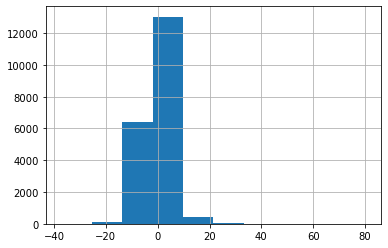

In [68]:
pd.Series(grid_search_tune.best_estimator_.steps[1][1].coef_[0]).hist()

In [77]:
coefs = grid_search_tune.best_estimator_.steps[1][1].coef_
without_bias = coefs - grid_search_tune.best_estimator_.steps[1][1].intercept_ * len(coefs)

features = grid_search_tune.best_estimator_.steps[0][1].get_feature_names()
important_features = []
for i in range(len(features)):
    if without_bias[0][i] >= 20.:
        important_features.append(features[i])

# Open

In [9]:
def get_files(path, ext):
    import os
    paths_to_files = []
    for root, dir, files in os.walk(path):
        if files:
            for f in files:
                if ext in f:
                    paths_to_files.append(os.path.join(root, f))
    if paths_to_files:
        return paths_to_files
    else:
        raise ValueError('No such directory')
# get_files('<path>', 'csv')

In [ ]:
# Update json
try:
    with open('.json') as json_file:
        data = json.load(json_file)
    data.update(user_data)
    json.dump(data, open(".json", 'w'))
except FileNotFoundError:
    json.dump(user_data, open(".json", 'w'))
user_data = {}

In [ ]:
import csv
new_labels1, new_corpus1 = [], []
with open('type_march_.csv', 'rt') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for n, i in enumerate(readCSV):
        # print(i)
        # break
        if n != 0:
            new_labels1.append(i[0])
            new_corpus1.append(i[1])

# Notes

In [ ]:
# create list of items from list of lists of items
flat_list = [item for sublist in t for item in sublist]

# sort dict by values
{k: v for k, v in sorted(result.items(), key=lambda item: item[1])}

In [ ]:
from copy import copy
def top_n_max(series, top=2, diraction=max):
    series = list(set(series.tolist()))
    if diraction == max:
      top_result = sorted(series)[-top:]
    else:
      top_result = sorted(series)[:top]
    return top_result